In [6]:
import numpy as np
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt

In [7]:
# Initialize parameters
num_samples = 20242  # Number of data points
num_samples_test = 677399
num_features = 47236  # Number of features
m = 2 * num_features

# Initialize the label array and the sparse matrix for features
b_lgt = np.zeros((num_samples, 1))
A_lgt = dok_matrix((num_samples, num_features), dtype=np.float32)

b_test = np.zeros((num_samples_test, 1))
A_test = dok_matrix((num_samples_test, num_features), dtype=np.float32)

# Read the file and fill the structures
with open('rcv1_train.binary', 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()  # Split by whitespace
        b_lgt[i] = int(parts[0])  # First part is the label
        for feature in parts[1:]:  # The rest are features
            index, value = feature.split(":")
            A_lgt[i, int(index) - 1] = float(value)  # Adjust for 0-based indexing

# Convert the sparse matrix to CSR format for better efficiency in later operations
A_lgt = A_lgt.tocsr()
b_lgt[b_lgt < 0] = 0

# For Testing Dataset
with open('rcv1_test.binary', 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()
        b_test[i] = int(parts[0])
        for feature in parts[1:]:
            index, value = feature.split(":")
            A_test[i, int(index) - 1] = float(value)

# Convert the sparse matrix to CSR format for better efficiency in later operations
A_test = A_test.tocsr()
b_test[b_test < 0] = 0

In [8]:
def calculate_accuracy(w, X, y_true, threshold=0.5):
    probs = 1 / (1 + np.exp(-X.dot(w)))
    predictions = (probs >= threshold).astype(int)
    accuracy = np.mean(predictions == y_true)
    return accuracy

In [9]:
lam_lgt = 0
def lgt_func(x):
    """ Logistic Regression Function
    """
    f = 0
    for i in range(A_lgt.shape[0]):
      f += np.log(1 + np.exp(A_lgt[i,:] @ x)) - b_lgt[i] * A_lgt[i,:] @ x
    f += lam_lgt / 2 * np.linalg.norm(x) ** 2
    return f

def lgt_grad(x):
    """ Find FULL gradient of logistic regression.
    """
    grad_f = np.zeros((A_lgt.shape[1], 1))
    for i in range(A_lgt.shape[0]):
      grad_f += np.transpose(A_lgt[i,:]) * np.exp(A_lgt[i,:] @ x) / (1 + np.exp(A_lgt[i,:] @ x)) - float(b_lgt[i]) * np.transpose(A_lgt[i,:])
    #grad_f += lam_lgt * x
    return grad_f



def lgt_grad_ind(x, ind: np.array):
    """ Find partial gradient of logistic regression, where ind contains indices of random gradients to be computed.
    """
    grad = np.zeros((A_lgt.shape[1], 1))
    for i in ind:
      grad += np.transpose(A_lgt[i,:]) * np.exp(A_lgt[i,:] @ x) / (1 + np.exp(A_lgt[i,:] @ x)) - float(b_lgt[i]) * np.transpose(A_lgt[i,:])
    grad = grad / len(ind)
    return grad


def lgt_grad_i(x, i: int):
    """ Find partial gradient of logistic regression, where i is the index of random gradient to be computed.
    """
    return np.transpose(A_lgt[i,:]) * np.exp(A_lgt[i,:] @ x) / (1 + np.exp(A_lgt[i,:] @ x)) - float(b_lgt[i]) * np.transpose(A_lgt[i,:])

In [10]:
def SVRG(w_0, full_grad, some_grad, step_size = 1, num_grad = 3, tol=1e-6, max_iter=50000):
    w = w_0.copy()
    err_list = list()
    acc_list = list()
    w_stored = w.copy()
    full_grad = full_grad(w_stored) / float(A_lgt.shape[0])

    iter_count = 0
    err = tol + 1.0
    while err >= tol:
        random_int = np.random.randint(0, 20242, size=num_grad)
        
        part_grad = some_grad(w, random_int)
        grad_stored = some_grad(w_stored, random_int)

        w_new = w - step_size * (part_grad - grad_stored + full_grad)

        iter_count += 1
        err = np.linalg.norm(w_new - w, 1)
        err_list.append(err)
        if m % A_lgt.shape[0] == 0:
            w_stored = w.copy()
            full_grad = full_grad(w_stored) / A_lgt.shape[0]
        if iter_count >= max_iter:
            print('SVRG reach maximum of iteration')
            return w, err_list, acc_list
        w = w_new.copy()
        if iter_count % 1000 ==0:
            acc_list.append(calculate_accuracy(w, A_test, b_test))

    return w, err_list, acc_list



def SAGA(w_0, A_lgt, b_lgt, lam_lgt=0, max_iter=50000, lr=1, tol=1e-6):
    n, d = A_lgt.shape
    w = w_0.copy()
    avg_grad = np.zeros((d, 1))
    stored_grads = np.zeros((n, d))
    err_list = list()
    acc_list = list()
    err = tol + 1.0
    iter_count = 0

    while err > tol:
        i = np.random.randint(n)
        grad_i = lgt_grad_i(w, i)
        
        # Update the average gradient with the new gradient and subtract the stored one
        avg_grad += (grad_i - stored_grads[i, :].reshape(d, 1)) / n
        
        # Update parameter w using the current gradient, average gradient, and regularization
        w_new = w - lr * (grad_i - stored_grads[i, :].reshape(d, 1) + avg_grad + lam_lgt * w)
        
        # Update
        stored_grads[i, :] = grad_i.reshape(1, -1)
        err = np.linalg.norm(w_new - w, 1)
        err_list.append(err)
        iter_count += 1
        if iter_count >= max_iter:
            print('SAGA reach maximum of iteration')
            return w, err_list, acc_list
        w = w_new.copy()
        if iter_count % 1000 ==0:
            acc_list.append(calculate_accuracy(w, A_test, b_test))
    return w, err_list, acc_list

In [11]:
w_svrg, err_svrg, acc_svrg = SVRG(np.ones((A_lgt.shape[1], 1)) / 20, lgt_grad, lgt_grad_ind)

SVRG reach maximum of iteration


In [12]:
w_saga, err_saga, acc_saga = SAGA(np.ones((A_lgt.shape[1], 1)) / 20, A_lgt, b_lgt)

SAGA reach maximum of iteration


In [13]:
print('Final SVRG Accuracy: ', acc_svrg[-1])
print('Final SAGA Accuracy: ', acc_saga[-1])

Final SVRG Accuracy:  0.9560997285204141
Final SAGA Accuracy:  0.9596161198938883


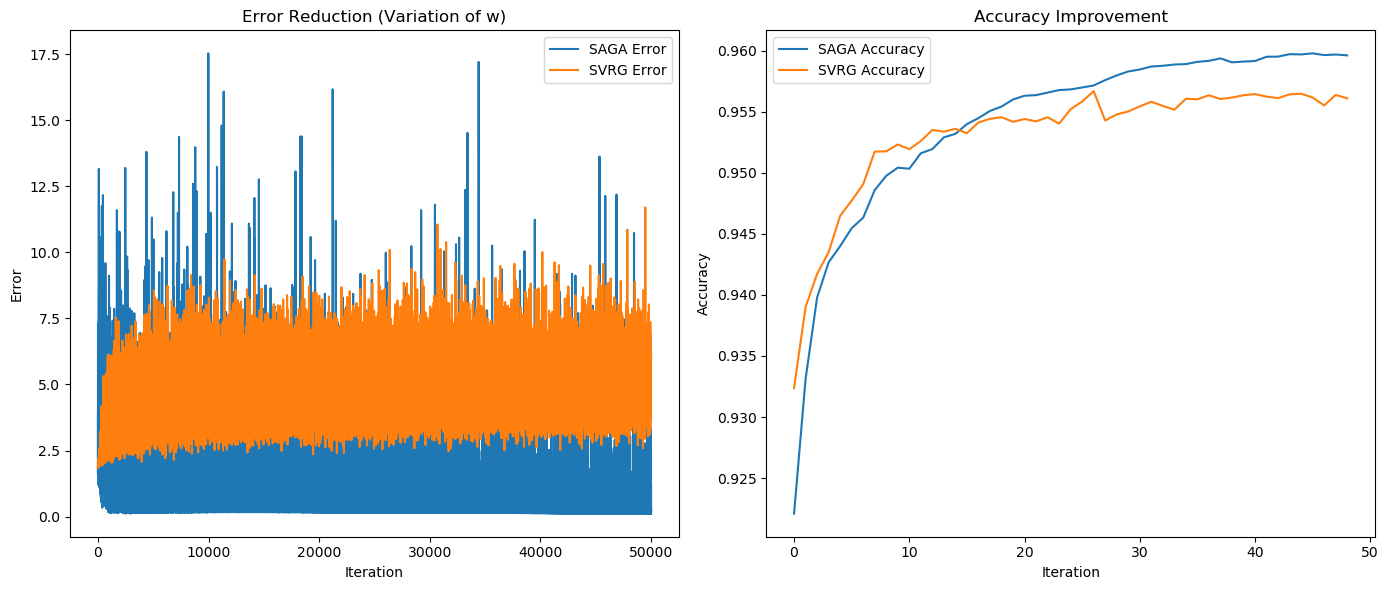

In [15]:
plt.figure(figsize=(14, 6))

# Plotting error reduction
plt.subplot(1, 2, 1)
plt.plot(err_saga, label='SAGA Error')
plt.plot(err_svrg, label='SVRG Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error Reduction (Variation of w)')
plt.legend()

# Plotting accuracy improvement
plt.subplot(1, 2, 2)
plt.plot(acc_saga, label='SAGA Accuracy')
plt.plot(acc_svrg, label='SVRG Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement')
plt.legend()

plt.tight_layout()
plt.show()